# Exponential Swept Sine Transfer Function Measurement
An implementation of the technique proposed by Angelo Farina at the 108th AES Convention in February 2000. Paper Number: 5093.

In [163]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

filepath = 'audio/'

Set parameters: sample rate $f_s$, lower frequency $f_1$, upper frequency $f_2$, sweep duration $T$.



In [164]:
f_s = 44100
f_1 = 20
f_2 = 20e3
T = 2

Generate sweep signal $x(t)= \sin\big[\frac{2πf_1T}{R}(e^{tR/T}-1)\big]$, where $R=\ln(f_2/f_1)$, and time-reversed deconvolution filter $f(t)$.


In [165]:
R = np.log(f_2 / f_1)
t = np.linspace(0, T, int(T * f_s), False)
x = np.sin((2 * np.pi * f_1 * T / R) * (np.exp(t * R / T) - 1))
f = np.flip(x) / np.exp(t * R / T)

Set amplitude $A$, zero pad duration $T_z$, and write $x(t)$ sweep to playfile.

In [166]:
playfile = filepath + 'esstrans-play.wav'
A = 10**(-3 / 20)
T_z = 0.1
x_play = A * np.concatenate((np.zeros(int(T_z * f_s)), x, np.zeros(int(T_z * f_s))))
wav.write(playfile, f_s, x_play.astype(np.float32))

Read recording $y(t)$ from recfile.

In [167]:
recfile = filepath + 'esstrans-rec.wav'
loopback = True
if loopback:
    x_rec = x_play + x_play**3    # Add 3rd harmonic.
    wav.write(recfile, f_s, x_rec.astype(np.float32))
f_s, y = wav.read(recfile)

Calculate impulse response $h(t) = y(t) \ast f(t)$, and scaling constant $k$

In [168]:
h = np.convolve(y, f, 'same')
k = 1 / np.sqrt(np.sum(np.square(h)))

Plot impulse response $h(t)$

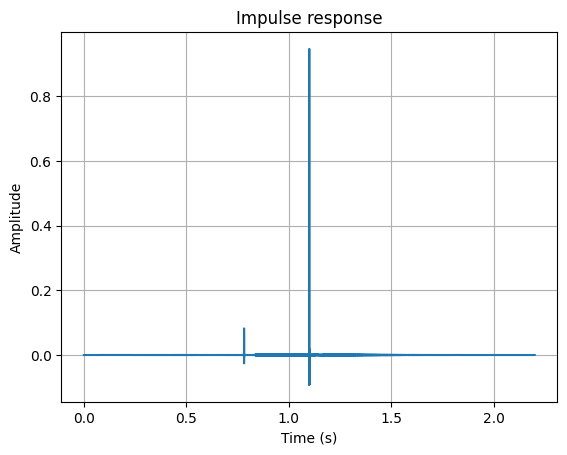

In [169]:
fig, axs = plt.subplots()

t = np.linspace(0, len(y) / f_s, len(y), False)
axs.plot(t, k * h)
axs.grid(True)
axs.set_title('Impulse response')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Amplitude');

Find fundamental response and calculate $N$th harmonic response time offset $Δt=T\ln(N)/R$

In [170]:
d1 = np.argmax(h)
N = 1
dt = T * np.log(N) / R
dn = d1 - int(f_s * dt)

Set fft length $L$, scale and window $h(t)$ for harmonic $N$, and calculate transfer function $H(f)$.

In [171]:
L = 4096
hh = k * h[dn - L // 2:dn + L // 2] * np.hanning(L)
H = np.fft.rfft(hh)

Plot harmonic response $hh(t)$ and transfer function $H(f)$.

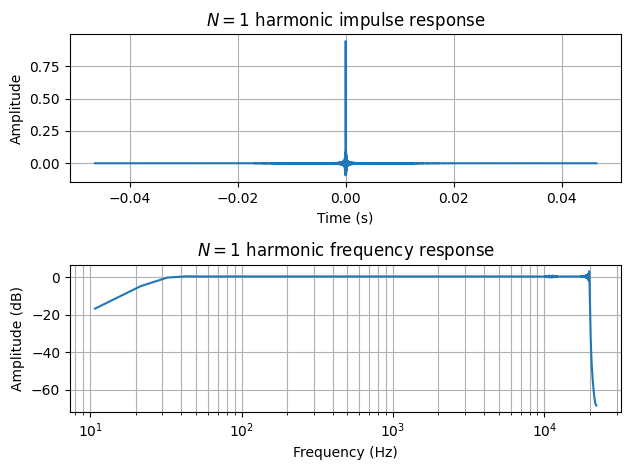

In [173]:
fig, axs = plt.subplots(2)

t = np.linspace(-L / (2 * f_s), L / (2 * f_s), L, False)
axs[0].plot(t, hh)
axs[0].grid(True)
axs[0].set_title(f'$N={N}$ harmonic impulse response')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

f = np.linspace(0, f_s / 2, L // 2 + 1)
axs[1].semilogx(f[1:], 20 * np.log10(np.abs(H[1:])));
axs[1].xaxis.grid(True, 'both')
axs[1].yaxis.grid(True)
axs[1].set_title(f'$N={N}$ harmonic frequency response')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (dB)')
plt.tight_layout()